In [1]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
train_df=pd.read_csv('./titanic/train.csv')
test_df=pd.read_csv('./titanic/test.csv')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#重复上一节的操作...
train_df['Cabin'].fillna('missing',inplace=True)
test_df['Cabin'].fillna('missing',inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0],inplace=True)
train_df['Age'].fillna(train_df['Age'].mean(),inplace=True)
test_df['Age'].fillna(train_df['Age'].mean(),inplace=True)
test_df['Fare'].fillna(train_df['Fare'].mean(),inplace=True)
import category_encoders as ce
del train_df['Name']
del train_df['Ticket']
del test_df['Name']
del test_df['Ticket']
del train_df['PassengerId']
del test_df['PassengerId']
label=train_df["Survived"]
del train_df["Survived"]
# target 
target_encoder = ce.TargetEncoder(cols=['Embarked','Cabin']).fit(train_df,label)
train_df=target_encoder.transform(train_df)
test_df=target_encoder.transform(test_df)

# one hot
onehot_encoder = ce.OneHotEncoder(cols=['Sex']).fit(train_df)
train_df=onehot_encoder.transform(train_df)
test_df=onehot_encoder.transform(test_df)

from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
#z-score归一化为例
standard_scaler=StandardScaler()
standard_scaler.fit(train_df)
new_train_df=pd.DataFrame(standard_scaler.transform(train_df),columns=train_df.columns)
new_test_df=pd.DataFrame(standard_scaler.transform(test_df),columns=train_df.columns)

In [3]:
# base line...
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, new_train_df, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7785468194526353, 0.04490418481133087)

### 简介
关于特征增强，可以考虑两个方向：   

（1）增加有用的特征： 

    这个就有些黑科技了，更多的是通过业务常识去造特征；

（2）去掉有害的特征，即**特征降维**，这又有两个方向：   

>（2.1）从原始特征集中去掉部分特征，这部分技术通常称为**特征选择**；   

>（2.2）将原始特征集映射为一个新的低维特征集，从而过滤掉高维空间中的噪声，这部分技术可以称为**特征变换**

### 一.增加有用的特征 

#### 1.1根据业务背景造特征

这部分不具有通用性...就不写代码了...对于titanic这个数据集，可以考虑从Name中提取一些特征，比如Mrs可以放映出该乘客已经结婚，Miss表示未婚小姐姐等...另外SibSp表示乘客兄弟姐妹/配偶的个数，而Parch表示乘客父母/孩子的个数，可以简单相加表示他们的家庭成员多少，越多的存活率可能越高...


#### 1.2添加聚类标签
聚类标签可以看作是对目前样本的做的特征映射，将高维空间相似的特征映射到相同的标签；这里演示用kmean生成聚类标签，利用calinski_harabaz选择较优的k

Text(0,0.5,'distortion degree')

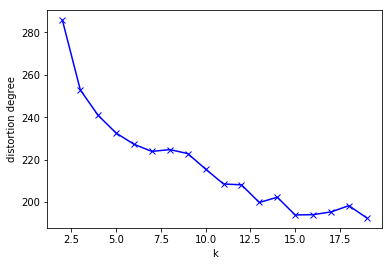

In [4]:
K=range(2,20)
calinski_harabaz_scores=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(new_train_df)
    calinski_harabaz_scores.append(metrics.calinski_harabaz_score(new_train_df, kmeans.predict(new_train_df)))
plt.plot(K,calinski_harabaz_scores,'bx-')
plt.xlabel('k')
plt.ylabel(u'distortion degree')

In [5]:
kmeans=KMeans(n_clusters=12)
kmeans.fit(new_train_df)
new_train_df['cluster_factor']=kmeans.predict(new_train_df)

In [6]:
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, new_train_df, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7804749461033647, 0.042362860092948845)

#### 1.3 多项式特征
简单来说就这样的过程：$[a,b]->[1,a,b,a^2,b^2,ab]$，通常用于构造“是/否”这样的特征，比如$a=0/1,b=0/1$，那么$ab=1$就表示$a=1$且$b=1$的情况   

**特别注意：构造多项式特征慎用，它以$O(n^2)$增涨特征量，如果原始有1000个特征，变换后会有100W个特征，建议单独对某一特征子集使用**

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)#
poly_fea_np=poly.fit_transform(train_df)
poly_fea_df=pd.DataFrame(poly_fea_np,columns=poly.get_feature_names())

In [8]:
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, poly_fea_df, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7790340389472006, 0.033251719990077054)

#### 1.4 自动构建组合特征
比较流行的一种方式是gbdt+lr,即利用gbdt探索不错的特征空间，然后用lr对这些特征空间张成one-hot特征进行拟合；  
![avatar](./source/gbdt_lr.png)
参考：https://www.cnblogs.com/wkang/p/9657032.html

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
n_trees=100
tree_depth=2#树的深度不必太深
kfold= KFold(n_splits=5,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(new_train_df,label):
    X_train=new_train_df.loc[train_index]
    y_train=label[train_index]
    X_test=new_train_df.loc[test_index]
    y_test=label[test_index]
    
    gbm1 = GradientBoostingClassifier(n_estimators=n_trees,max_depth=tree_depth)
    gbm1.fit(X_train, y_train)
    train_new_feature = gbm1.apply(X_train)
    train_new_feature = train_new_feature.reshape(-1, n_trees)

    enc = OneHotEncoder()

    enc.fit(train_new_feature)

    # # # 每一个属性的最大取值数目
    # # print('每一个特征的最大取值数目:', enc.n_values_)
    # # print('所有特征的取值数目总和:', enc.n_values_.sum())

    train_new_feature2 = np.array(enc.transform(train_new_feature).toarray())

    #训练lr
    lr=LogisticRegression()
    lr.fit(train_new_feature2,y_train)
    #测试
    test_new_feature = gbm1.apply(X_test)
    test_new_feature = test_new_feature.reshape(-1, n_trees)
    test_new_feature2 = np.array(enc.transform(test_new_feature).toarray())

    y_predict=lr.predict(test_new_feature2)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7725114798293671, 0.01960145339940876)

### 二. 特征选择
特征选择主要有两个方向：   

（1）基于统计指标：方差、相关性、gini、info gain、chi2，统计指标其实在一开始的数据清洗阶段也有用到    

（2）基于模型指标：RFE递归删减特征、训练基模型，选择权值系数较高的特征  

#### 删除低方差特征
在我们造的特征中可能会产生一些低方差特征，这类特征往往倾斜严重

In [10]:
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
VarianceThreshold(threshold=0.01).fit_transform(poly_fea_df).shape

(891, 50)

In [11]:
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, VarianceThreshold(threshold=0.01).fit_transform(poly_fea_df), label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7866156425794545, 0.027746067690248344)

#### 选择高相关性特征
变相排除低相关性特征

In [12]:
import copy
copy_df=copy.deepcopy(poly_fea_df)
copy_df['Survived']=label
copy_df.corr()['Survived'].abs().sort_values(ascending=False).head(5)

Survived    1.000000
x2 x8       0.548295
x1          0.543351
x2          0.543351
x1^2        0.543351
Name: Survived, dtype: float64

In [13]:
#选择相关性>0.2的因子建模，注意要去掉Survived
highly_correlated_features = copy_df.columns[copy_df.corr()['Survived'].abs() > 0.1]
highly_correlated_features = highly_correlated_features.drop('Survived')
high_corr_features_df=copy_df[highly_correlated_features]

In [14]:
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, high_corr_features_df, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7905768103351534, 0.03280111455743408)

#### 选择高gini指数特征
要计算gini指数，可以通过训练决策树得到

In [15]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()#如果要用信息增益，设置criterion='entropy'
tree.fit(poly_fea_df,label)
importances = pd.DataFrame({ 'feature':poly_fea_df.columns,'importance': tree.feature_importances_}).sort_values('importance', ascending=False)
importances.head()

,feature,importance
20,x1 x3,0.347396
0,x0,0.086186
15,x0 x6,0.067206
7,x7,0.056080
36,x3 x6,0.049074


In [16]:
#选择top因子建模
select_features=importances['feature'].tolist()[:50]
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, poly_fea_df[select_features], label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7810221130326891, 0.03470329254309837)

#### 选择高chi2特征

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#选择前50个特征
top_50_feature_df=SelectKBest(chi2, k=50).fit_transform(poly_fea_df, label)
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, top_50_feature_df, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7882105223722208, 0.036066492211802935)

#### RFE递归消除
就是一个一个删掉去试，一般不用，跑的太慢了....

In [18]:
# from sklearn.feature_selection import RFE
# rfe_df=RFE(estimator=GradientBoostingClassifier(), n_features_to_select=50).fit_transform(poly_fea_df, label)
# classifier=GradientBoostingClassifier()
# scores = cross_val_score(classifier, rfe_df, labels, scoring='f1', cv = 5)
# np.mean(scores),np.std(scores)

#### 基于模型选特征
其实这里和gini系数的选择一样，通过训练一个模型来选择特征最优特征，然后再去训练一个模型，只是这里选择特征用的模型与训练用的模型一样

In [19]:
gbdt = GradientBoostingClassifier()
gbdt.fit(poly_fea_df,label)
importances = pd.DataFrame({ 'feature':poly_fea_df.columns,'importance': gbdt.feature_importances_}).sort_values('importance', ascending=False)
importances.head()

,feature,importance
20,x1 x3,0.456122
9,x0^2,0.074019
12,x0 x3,0.047668
52,x7 x8,0.044320
50,x6 x8,0.042022


In [20]:
#选择top因子建模
select_features=importances['feature'].tolist()[:50]
features_select_top_50_df=poly_fea_df[select_features]
#gbdt
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,features_select_top_50_df,label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7827012697429128, 0.035156370587767695)

#### SelectFromModel自动选择最优特征

In [21]:
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
top_nums=[]
for train_index,test_index in kfold.split(poly_fea_df,label):
    X_train=poly_fea_df.loc[train_index]
    y_train=label[train_index]
    X_test=poly_fea_df.loc[test_index]
    y_test=label[test_index]
    
    select_feature_model = SelectFromModel(GradientBoostingClassifier())
    X_new_train=select_feature_model.fit_transform(X_train,y_train)
    
    X_new_test=select_feature_model.transform(X_test)
    
    _,top_num=X_new_test.shape
    top_nums.append(top_num)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_new_train,y_train)
    y_predict=gbdt.predict(X_new_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7637325156867544, 0.05080842842696327)

### 三.特征转换
不同于特征选择，特征转换是将原始特征空间映射到了一个新的低维（往往是）空间中，梳理了如下这些方法：   

（1）pca:主成分分析；   

（2）lda:线性判别分析；   

（3）lle:局部线性嵌入；   

（4）ae:自编码；   

（5）vae:变分自编码；

#### pca
pca是一种无监督的线性降维方式，它构建了一个新的正交坐标系，相应的坐标轴分别叫“第一主成分”，“第二主成分”...，且数据在“第一主成分”坐标轴上**方差**最大，“第二主成分”其次，...通常可以只取前n个主成分，将方差较小的主成分理解为**噪声**；  
![avatar](./source/pca示例.png)
更多：https://blog.csdn.net/program_developer/article/details/80632779 

In [22]:
from sklearn.decomposition import PCA
standard_df=StandardScaler().fit_transform(poly_fea_df)
X_pca=PCA(n_components=20).fit_transform(standard_df)

In [23]:
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_pca, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7570897942864615, 0.05234462942327912)

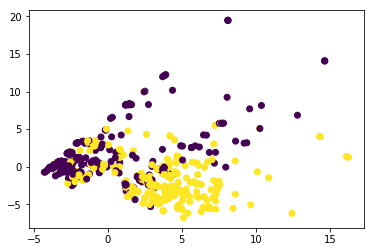

In [24]:
# 前两维的效果
plt.scatter(X_pca[:, 0], X_pca[:, 1],marker='o',c=label)
plt.show()

#### lda
lda是一种线性的有监督降维方式，与pca的最大化方差的目标不同，它的目标是找到这样的新坐标轴：**同类样例的投影尽可能近，异类样例的投影点尽可能远**；  
更多：https://blog.csdn.net/weixin_40604987/article/details/79615968

In [25]:
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
kfold= KFold(n_splits=5,random_state=42,shuffle=True)
scores=[]
for train_index,test_index in kfold.split(poly_fea_df,label):
    X_train=poly_fea_df.loc[train_index]
    y_train=label.loc[train_index]
    X_test=poly_fea_df.loc[test_index]
    y_test=label.loc[test_index]
    
    lda=LinearDiscriminantAnalysis(n_components=20)
    lda.fit(X_train, y_train)
    
    X_new_train=lda.transform(X_train)
    X_new_test=lda.transform(X_test)
    
    gbdt=GradientBoostingClassifier()
    gbdt.fit(X_new_train,y_train)
    y_predict=gbdt.predict(X_new_test)
    f1_score=metrics.f1_score(y_test,y_predict)
    scores.append(f1_score)
np.mean(scores),np.std(scores)

(0.7230947045846136, 0.03832196912050019)

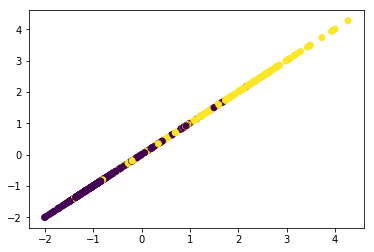

In [26]:
plt.scatter(X_new_train[:, 0], X_new_train[:, 0],marker='o',c=y_train)
plt.show()

#### lle-局部线性嵌入（LocallyLinearEmbedding）
降维时保持样本局部的线性特征
![avatar](./source/lle示例.jpg)
更多：https://www.cnblogs.com/pinard/p/6266408.html?utm_source=itdadao&utm_medium=referral

In [27]:
from sklearn.manifold import LocallyLinearEmbedding
X_lle=LocallyLinearEmbedding(n_components=20).fit_transform(poly_fea_df)
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier,X_lle, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.5623881209232492, 0.0636799703332207)

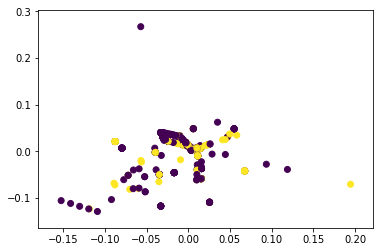

In [28]:
plt.scatter(X_lle[:, 0], X_lle[:, 1],marker='o',c=label)
plt.show()

#### ae-自编码  
可以把它看做一个压缩和解压的过程，如下，通过encoder把一个高维的数据压缩为低维的数据，再通过decoder将低维数据还原为高维的数据，这样这个低维的数据可以看做高维数据的一种“不失真”表示，编码器和解码器通常使用神经网络...   

![avatar](./source/ae.png)  


In [29]:
# from keras.models import Model
# from keras.layers import *

# #定义网络结构
# epochs=200
# batch_size=128
# input_dim=poly_fea_df.shape[1]

# input_layer=Input(shape=(input_dim,))
# encode_layer=Dense(2,activation='relu',name='encoder')(input_layer)
# decode_layer=Dense(input_dim,activation='tanh')(encode_layer)

# model=Model(inputs=input_layer,outputs=decode_layer)
# #获取encode_layer层的输出
# encode_layer_model = Model(inputs=model.input,outputs=model.get_layer('encoder').output)
# model.compile('adam',loss='mse')

In [30]:
#训练模型
# model.fit(poly_fea_df[:500],poly_fea_df[:500],batch_size=batch_size,epochs=epochs,validation_data=[poly_fea_df[500:],poly_fea_df[500:]])

####  vae-变分自编码
会让中间层的编码数据更加趋近于高斯分布  

参考：https://blog.csdn.net/weixin_41923961/article/details/81586082